In [1]:
from greedy_mcmc_attack import *

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# dataset_directory = "../Cora"
cora_dataset = Planetoid(root='', name='Cora')
data = cora_dataset[0].to(device)
print(data)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [4]:
model = GCN(data.x.shape[1], cora_dataset.num_classes, [16]).to(device)

In [5]:
model.reset_parameters()
train = Trainable(model)
train.fit(data, 200)

Epoch 0, Train Loss - 4.631275177001953, Val Loss - 5.002750873565674, Val Accuracy - 0.113
Epoch 20, Train Loss - 0.438211590051651, Val Loss - 1.6188753843307495, Val Accuracy - 0.548
Epoch 40, Train Loss - 0.2816329598426819, Val Loss - 2.1769580841064453, Val Accuracy - 0.695
Epoch 60, Train Loss - 0.1389736384153366, Val Loss - 2.1234090328216553, Val Accuracy - 0.705
Epoch 80, Train Loss - 0.09741013497114182, Val Loss - 2.3201329708099365, Val Accuracy - 0.72
Epoch 100, Train Loss - 0.0785134881734848, Val Loss - 2.256194591522217, Val Accuracy - 0.726
Epoch 120, Train Loss - 0.10981370508670807, Val Loss - 2.8264715671539307, Val Accuracy - 0.733
Epoch 140, Train Loss - 0.07886074483394623, Val Loss - 2.689803123474121, Val Accuracy - 0.734
Epoch 160, Train Loss - 0.046231821179389954, Val Loss - 3.0960278511047363, Val Accuracy - 0.689
Epoch 180, Train Loss - 0.09418679773807526, Val Loss - 2.7338900566101074, Val Accuracy - 0.727
Epoch 200, Train Loss - 0.06851238757371902, V

In [6]:
# # Get initial accuracy
# initial_loss, initial_accuracy = train.test(data)
# print(f"Initial Accuracy: {initial_accuracy}")
# print(f"Initial Loss: {initial_loss}")

In [7]:
edges_to_add = None

In [8]:
# # save model
# model_save_path = "multi_metattack_gcn_model.pth"
# torch.save(model.state_dict(), model_save_path)

# # save edges
# list_save_path = "multi_metattack_edges_list.pth"
# torch.save(edges_to_add, list_save_path)

In [9]:
# loaded_model_state_dict = torch.load(model_save_path)

# model = GCN(data.x.shape[1], cora_dataset.num_classes, [16]).to(device)
# model.load_state_dict(loaded_model_state_dict)

# # Load the saved list
# edges_to_add = torch.load(list_save_path)

In [10]:
model_save_path = "multi_metattack_gcn_model.pth"
list_save_path = "multi_metattack_edges_list.pth"

In [11]:
model, edges_to_add, train = load_model_and_edges(model_save_path, list_save_path, data.x.shape[1], cora_dataset.num_classes, [16], device)

In [12]:
G, initial_edge_count, ptb_rate, budget = initialize(data, _ptb_rate=0.15)

In [19]:
len(edges_to_add)

3633

In [13]:
# def two_phase_attack(split):
#     diff_threshold = abs(initial_loss/200)
#     first_phase_edges = int(budget * split)
#     second_phase_percent = ptb_rate * (1 - split) * 1/2
#     print(second_phase_percent)
#     accuracies = []
#     G = to_networkx(data, to_undirected=True)
    
#     data_copy = copy.copy(data)
#     i, j = 0, 0 # i - number added, j - spot in list
#     while i < first_phase_edges:
#         u, v = edges_to_add[j]
    
#         G.add_edge(u, v)
    
#         modified_data = from_networkx(G).to(device)
#         modified_data.x = data.x 
#         modified_data.y = data.y 
#         modified_data.train_mask = data.train_mask
#         modified_data.test_mask = data.test_mask
    
#         modified_loss, modified_accuracy = train.test(modified_data)
#         # print(modified_loss)
    
#         if (abs(modified_loss - initial_loss) / max(modified_loss, initial_loss)) <= diff_threshold:
#         # if modified_accuracy == initial_accuracy:
#             # print(modified_accuracy, i)
#             i += 1
#             # accuracies.append(modified_accuracy)
#             accuracies.append(modified_loss)
#         else:
#             # print(i, 'miss!')
#             G.remove_edge(u, v)
            
#         j += 1
    
#     modified_data = from_networkx(G).to(device)
#     modified_data.x = data.x 
#     modified_data.y = data.y 
#     modified_data.train_mask = data.train_mask
#     modified_data.test_mask = data.test_mask
    
#     attacker = Metattack(modified_data, device=device)
#     attacker.setup_surrogate(model,
#                              labeled_nodes=data.train_mask,
#                              unlabeled_nodes=data.test_mask, lambda_=0.)
#     attacker.reset()
#     attacker.attack(second_phase_percent)

#     degs = defaultdict(tuple)
    
#     for k, v in attacker._added_edges.items():
#         degs[v] = (k, True)
        
#     for k, v in attacker._removed_edges.items():
#         degs[v] = (k, False)
    
#     for _, second in degs.items():
#         u, v = second[0]
#         if second[1]:
#             G.add_edge(u, v)
#         else:
#             G.remove_edge(u, v)
    
#         modified_data = from_networkx(G).to(device)
#         modified_data.x = data.x 
#         modified_data.y = data.y 
#         modified_data.train_mask = data.train_mask
#         modified_data.test_mask = data.test_mask
    
#         modified_loss, modified_accuracy = train.test(modified_data)
    
#         # accuracies.append(modified_accuracy)
#         accuracies.append(modified_loss)

#     print(accuracies)
#     return accuracies

In [14]:
splits = [0, 0.5, 0.7, 0.9]
split_dic_acc = defaultdict(list)
split_dic_loss = defaultdict(list)
itrs = defaultdict(int)

In [15]:
for s in splits:
    print(s)
    split_dic_acc[s], split_dic_loss[s], itrs[s] = two_phase_attack_greedy(data, train, model, s, edges_to_add, constant_fn, device, verbose=True)

0.5


Peturbing graph...:   0%|          | 0/197 [00:00<?, ?it/s]

Attempt: 0, Selected: 0
Attempt: 1, Selected: 0
Attempt: 2, Selected: 0
Attempt: 13, Selected: 10
Attempt: 25, Selected: 20
Attempt: 35, Selected: 30
Attempt: 45, Selected: 40
Attempt: 55, Selected: 50
Attempt: 65, Selected: 60
Attempt: 75, Selected: 70
Attempt: 85, Selected: 80
Attempt: 86, Selected: 80
Attempt: 96, Selected: 90
Attempt: 106, Selected: 100
Attempt: 116, Selected: 110
Attempt: 126, Selected: 120
Attempt: 136, Selected: 130
Attempt: 149, Selected: 140
Attempt: 150, Selected: 140
Attempt: 160, Selected: 150
Attempt: 171, Selected: 160
Attempt: 181, Selected: 170
Attempt: 192, Selected: 180
Attempt: 203, Selected: 190


Peturbing graph...:   0%|          | 0/204 [00:00<?, ?it/s]

0.7


Peturbing graph...:   0%|          | 0/118 [00:00<?, ?it/s]

Attempt: 0, Selected: 0
Attempt: 12, Selected: 10
Attempt: 23, Selected: 20
Attempt: 33, Selected: 30
Attempt: 43, Selected: 40
Attempt: 53, Selected: 50
Attempt: 63, Selected: 60
Attempt: 73, Selected: 70
Attempt: 84, Selected: 80
Attempt: 94, Selected: 90
Attempt: 104, Selected: 100
Attempt: 114, Selected: 110
Attempt: 124, Selected: 120
Attempt: 134, Selected: 130
Attempt: 145, Selected: 140
Attempt: 157, Selected: 150
Attempt: 168, Selected: 160
Attempt: 178, Selected: 170
Attempt: 188, Selected: 180
Attempt: 198, Selected: 190
Attempt: 208, Selected: 200
Attempt: 218, Selected: 210
Attempt: 228, Selected: 220
Attempt: 238, Selected: 230
Attempt: 238, Selected: 230
Attempt: 248, Selected: 240
Attempt: 259, Selected: 250
Attempt: 269, Selected: 260
Attempt: 279, Selected: 270


Peturbing graph...:   0%|          | 0/124 [00:00<?, ?it/s]

0.9


Peturbing graph...:   0%|          | 0/39 [00:00<?, ?it/s]

Attempt: 0, Selected: 0
Attempt: 13, Selected: 10
Attempt: 25, Selected: 20
Attempt: 35, Selected: 30
Attempt: 45, Selected: 40
Attempt: 55, Selected: 50
Attempt: 65, Selected: 60
Attempt: 76, Selected: 70
Attempt: 87, Selected: 80
Attempt: 97, Selected: 90
Attempt: 107, Selected: 100
Attempt: 117, Selected: 110
Attempt: 127, Selected: 120
Attempt: 137, Selected: 130
Attempt: 147, Selected: 140
Attempt: 158, Selected: 150
Attempt: 168, Selected: 160
Attempt: 178, Selected: 170
Attempt: 188, Selected: 180
Attempt: 201, Selected: 190
Attempt: 211, Selected: 200
Attempt: 221, Selected: 210
Attempt: 232, Selected: 220
Attempt: 242, Selected: 230
Attempt: 252, Selected: 240
Attempt: 262, Selected: 250
Attempt: 273, Selected: 260
Attempt: 283, Selected: 270
Attempt: 296, Selected: 280
Attempt: 306, Selected: 290
Attempt: 317, Selected: 300
Attempt: 328, Selected: 310
Attempt: 338, Selected: 320
Attempt: 348, Selected: 330
Attempt: 358, Selected: 340
Attempt: 368, Selected: 350


Peturbing graph...:   0%|          | 0/41 [00:00<?, ?it/s]

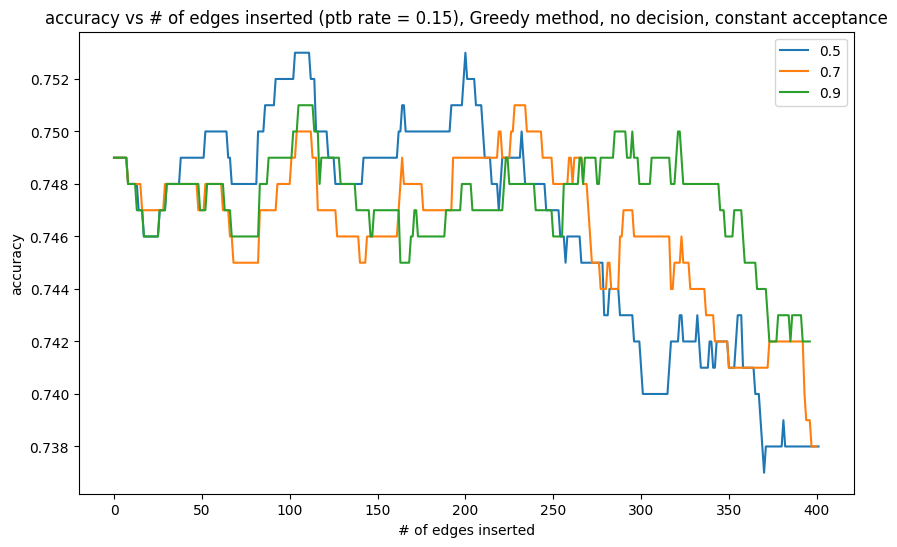

In [16]:
plot_results(split_dic_acc, ptb_rate, "Greedy", "no", "constant", "accuracy")

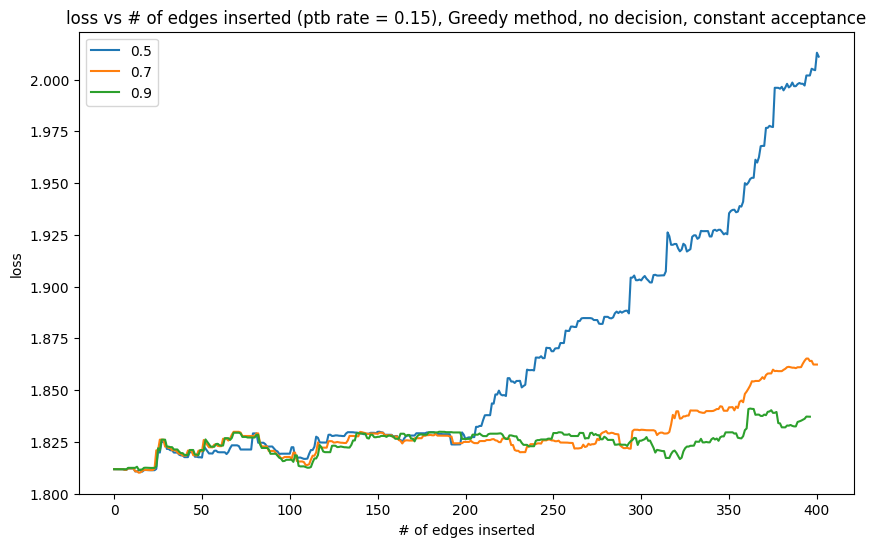

In [17]:
plot_results(split_dic_loss, ptb_rate, "Greedy", "no", "constant", "loss")

In [18]:
itrs

defaultdict(int,
            {0.5: 1.0606060606060606,
             0.7: 1.0288808664259927,
             0.9: 1.0561797752808988})